## 1: Enable TPU


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.0
Running on TPU  ['10.36.134.50:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.36.134.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.36.134.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## 2: Import required libraries


In [2]:
pip install PyArabic

     |████████████████████████████████| 112kB 6.8MB/s 
  Created wheel for PyArabic: filename=PyArabic-0.6.10-cp36-none-any.whl size=113324 sha256=f91061e305aee0232953a021fd57bc512bfd5bafd62faa1b8b9d1b2d4f6c4273
  Stored in directory: /root/.cache/pip/wheels/10/b8/f5/b7c1a50e6efb83544844f165a9b134afe7292585465e29b61d
Successfully built PyArabic


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import time
import keras
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.utils import shuffle
import os
from nltk.translate.bleu_score import corpus_bleu
from time import sleep
import sys
from tqdm import tqdm
import tensorflow_hub as hub
import re
import pyarabic.araby as araby

## 3: Generating required datasets

In [4]:
# read sport news dataset
dataset = pd.read_csv("/content/drive/MyDrive/datasets/news_sport_dataset.csv", encoding='utf-8')
print(dataset.head())

   Unnamed: 0  ...                                            Article
0           0  ...  \nجدد المنتخب المصري فوزه على مضيفه منتخب إي س...
1           1  ...  \nرغم التقدم المريح الذي حققه ليفربول الإنجليز...
2           2  ...  \nحقق هيوستن روكتس رقما قياسيا جديدا للنادي، ا...
3           3  ...  \nدبي، الإمارات العربية المتحدة (CNN)-- أعلن ا...
4           4  ...  \nأبدى المدافع الكرواتي فيدران تشورلوكا، الأرب...

[5 rows x 4 columns]


In [5]:
# prepare sentences 
def sent_preparation(sentence):
  # remove tashkeel
  sentence = araby.strip_tashkeel(sentence)
  # remove unnecessary char
  sentence = sentence.replace("*","")
  # remove newline char
  sentence = sentence.replace("\n","")
  # remove repeated hyphens
  regex = re.compile(r"/(.)\1{3,}/")
  sentence = regex.sub("", sentence)
  # remove hyphens
  sentence = sentence.replace("- - - -","")
  sentence = sentence.replace("- - -","")
  sentence = sentence.replace("- -","")
  #remove repeted dots
  reg_r_dots = re.compile(r'\.{2,}')
  sentence = reg_r_dots.sub('', sentence)
  # remove double quotation
  sentence = sentence.replace('"','')
  # covert any english coma to arabic sample
  sentence = sentence.replace(",", "،")
  # add space before punctuation marks
  sentence = re.sub('([-.,!?؟،:()])', r' \1 ', sentence)
  sentence = re.sub('\s{2,}', ' ', sentence)
  sentence = ' '.join(sentence.split())
  return sentence

In [6]:
# prepare article text
dataset['Article'] = dataset['Article'].map(lambda sentence: sent_preparation(sentence))
# show sample
print(dataset['Article'].iloc[0])
# get all articles content
content = dataset['Article'].values
content = " ".join(content)
content[:400]

جدد المنتخب المصري فوزه على مضيفه منتخب إي سواتيني ، 2 - صفر ، خلال الجولة الرابعة من تصفيات كأس أمم أفريقيا ، على استاد السلام بالقاهرة ، الثلاثاء . وحملت ثنائية الفراعنة توقيع أحمد حجازي ( 19 ) مروان محسن ( 53 ) . وبهذه النتيجة رفع منتخب الفراعنة رصيده إلى 9 نقاط في المجموعة 11 من التصفيات ، والتي تضم إلى جانبه كلا من تونس وإي سواتيني والنيجر . وكانت مباراة الذهاب قد انتهت بفوز رفاق محمد صلاح على إي سواتيني 4 - 1 . وشهدت المباراة غياب نجم ليفربول محمد صلاح ، بداعي إصابة تعرض لها في مباراة الذهاب . وبخسارتها الثالثة في أربع جولات مقابل تعادل واحد ، أصبحت إي سواتيني خارج حسابات التأهل إلى النهائيات التي يبلغها بطل ووصيف المجموعة ، وفي حال تعادل تونس أو فوزها لاحقا على النيجر ( نقطة واحدة ) ، ستضمن مع مصر بلوغها النهائيات ، قبل جولتين على نهاية التصفيات .


'جدد المنتخب المصري فوزه على مضيفه منتخب إي سواتيني ، 2 - صفر ، خلال الجولة الرابعة من تصفيات كأس أمم أفريقيا ، على استاد السلام بالقاهرة ، الثلاثاء . وحملت ثنائية الفراعنة توقيع أحمد حجازي ( 19 ) مروان محسن ( 53 ) . وبهذه النتيجة رفع منتخب الفراعنة رصيده إلى 9 نقاط في المجموعة 11 من التصفيات ، والتي تضم إلى جانبه كلا من تونس وإي سواتيني والنيجر . وكانت مباراة الذهاب قد انتهت بفوز رفاق محمد صلاح عل'

In [7]:
# split articles to a fixed sequence length
def splitTextToSequences(string, lenght=10):
    words = string.split()
    grouped_words = [' '.join(words[i: i + lenght]) for i in range(0, len(words), lenght)]
    return grouped_words

In [8]:
# split dataset to sup sequenses
lines = splitTextToSequences(content) 
print('Number of sequnces: ', len(lines))
print("Samle ========================>")
print(lines[0])

Number of sequnces:  161571
Samle ========================>
جدد المنتخب المصري فوزه على مضيفه منتخب إي سواتيني ،


In [9]:
# mask sentence words
def mask (sentence):
  sentence = sentence.split()
  if len(sentence) > 0:
    punc_lsit = ["؟", ".", ":", "!", ",", "?", "،"]
    for id, word in enumerate(sentence):
      if word in punc_lsit:
        continue
      sentence[id] = 'space'
    return " ".join(sentence)

# remove punctionation marks
def remove_punctionation(sentence):
  return "".join(u for u in sentence if u not in ("؟", ".", ":", "!", ",", "?", "،"))

# check if sentence have punc
def has_punctuations(sentence):
  punc_lsit = ["؟", ".", ":", "!", ",", "?", "،"]
  # checking if string contains list element 
  res = [ele for ele in punc_lsit if(ele in sentence)]
  return bool(res)

In [10]:
# remove all sequences that not have any punctuation marks
lines_filtered = filter(lambda x: has_punctuations(x) == True, lines)

# creating source dataset 
source_df = pd.DataFrame(lines_filtered, columns= ['sentences'])
source_df['sentences']

0         جدد المنتخب المصري فوزه على مضيفه منتخب إي سوا...
1               2 - صفر ، خلال الجولة الرابعة من تصفيات كأس
2         أمم أفريقيا ، على استاد السلام بالقاهرة ، الثل...
3            محسن ( 53 ) . وبهذه النتيجة رفع منتخب الفراعنة
4             رصيده إلى 9 نقاط في المجموعة 11 من التصفيات ،
                                ...                        
113420    للرياضة بالنجاح . وواصل : نيل رضا جمهور الأهلي...
113421    إلى تعب كبير ، وأسعى لقيادة النادي إلى منصات ا...
113422       ، وختم قائلا : سنجدد مع بعض اللاعبين الأجانب ،
113423    بينما سيحدد الجهاز الفني الجديد هوية اللاعبين ...
113424                         المدرب الجديد خلال 10 أيام .
Name: sentences, Length: 113425, dtype: object

In [11]:
source_df['sentences'] = source_df['sentences'].map(lambda sentence: remove_punctionation(sentence))
source_df['sentences'].iloc[0]

'جدد المنتخب المصري فوزه على مضيفه منتخب إي سواتيني '

In [12]:
print(source_df)

                                                sentences
0       جدد المنتخب المصري فوزه على مضيفه منتخب إي سوا...
1              2 - صفر  خلال الجولة الرابعة من تصفيات كأس
2       أمم أفريقيا  على استاد السلام بالقاهرة  الثلاثاء 
3           محسن ( 53 )  وبهذه النتيجة رفع منتخب الفراعنة
4            رصيده إلى 9 نقاط في المجموعة 11 من التصفيات 
...                                                   ...
113420  للرياضة بالنجاح  وواصل  نيل رضا جمهور الأهلي ي...
113421  إلى تعب كبير  وأسعى لقيادة النادي إلى منصات ال...
113422         وختم قائلا  سنجدد مع بعض اللاعبين الأجانب 
113423  بينما سيحدد الجهاز الفني الجديد هوية اللاعبين ...
113424                        المدرب الجديد خلال 10 أيام 

[113425 rows x 1 columns]


In [13]:
# save source dataset
source_df.to_csv ('/content/drive/MyDrive/datasets/source_sentence_dataset.csv', header=True)

In [14]:
# remove all sequences that not have any punctuation marks
lines_filtered = filter(lambda x: has_punctuations(x) == True, lines)

# creating target dataset  
target_df = pd.DataFrame(lines_filtered, columns= ['sentences'])
target_df['sentences'] = target_df['sentences'].map(lambda sentence: mask(sentence))
target_df['sentences'].iloc[0]

'space space space space space space space space space ،'

In [15]:
print(target_df)

                                                sentences
0       space space space space space space space spac...
1       space space space ، space space space space sp...
2         space space ، space space space space ، space .
3       space space space space . space space space sp...
4       space space space space space space space spac...
...                                                   ...
113420  space space . space : space space space space ...
113421  space space space ، space space space space sp...
113422    ، space space : space space space space space ،
113423  space space space space space space space spac...
113424                    space space space space space .

[113425 rows x 1 columns]


In [18]:
# save source target
target_df.to_csv ('/content/drive/MyDrive/datasets/target_sentence_dataset.csv', header=True)

## 4: Preparing Datasets

In [24]:
def preprocess_sentence(sentence):
    sentence = sentence.replace("\n","")
    sentence = ' '.join(sentence.split())
    text = '<start> '+ sentence + ' <end>'
    return text

# calculates the max length in tensor
def calculate_max_length(tensor):
    return max(len(t) for t in tensor)

# convert inputs to numeric sequences with the maximum length
def tokenize(text):
    # Choose the top 20000 words from the vocabulary
    top_k = 20000
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>",filters='')
    tokenizer.fit_on_texts(text)
    train_seqs = tokenizer.texts_to_sequences(text)

    #add a word for padding 
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

    # Create the tokenized vectors
    text_seqs = tokenizer.texts_to_sequences(text)

    # Pad each vector to the max_length of the vector
    text_vector = tf.keras.preprocessing.sequence.pad_sequences(text_seqs, padding='post')

    # Calculates the max_length, which is used to store the attention weights
    max_length = calculate_max_length(text_seqs)
    
    return tokenizer, text_vector, max_length

In [20]:
# load source dataset
source_dataset = pd.read_csv("/content/drive/MyDrive/datasets/source_sentence_dataset.csv", encoding='utf-8')
#source_dataset.drop(source_dataset.tail(1).index,inplace=True)
source_dataset

,Unnamed: 0,sentences
0,0,جدد المنتخب المصري فوزه على مضيفه منتخب إي سوا...
1,1,2 - صفر خلال الجولة الرابعة من تصفيات كأس
2,2,أمم أفريقيا على استاد السلام بالقاهرة الثلاثاء
3,3,محسن ( 53 ) وبهذه النتيجة رفع منتخب الفراعنة
4,4,رصيده إلى 9 نقاط في المجموعة 11 من التصفيات
...,...,...
113420,113420,للرياضة بالنجاح وواصل نيل رضا جمهور الأهلي ي...
113421,113421,إلى تعب كبير وأسعى لقيادة النادي إلى منصات ال...
113422,113422,وختم قائلا سنجدد مع بعض اللاعبين الأجانب
113423,113423,بينما سيحدد الجهاز الفني الجديد هوية اللاعبين ...


In [22]:
# load target dataset
target_dataset = pd.read_csv("/content/drive/MyDrive/datasets/target_sentence_dataset.csv", encoding='utf-8')
#target_dataset.drop(target_dataset.tail(1).index,inplace=True)
target_dataset

,Unnamed: 0,sentences
0,0,space space space space space space space spac...
1,1,space space space ، space space space space sp...
2,2,space space ، space space space space ، space .
3,3,space space space space . space space space sp...
4,4,space space space space space space space spac...
...,...,...
113420,113420,space space . space : space space space space ...
113421,113421,space space space ، space space space space sp...
113422,113422,، space space : space space space space space ،
113423,113423,space space space space space space space spac...


In [25]:
# prepare input data
source_dataset['sentences'] = source_dataset['sentences'].map(lambda sentence: preprocess_sentence(sentence))
input_tokenizer, input_tensor ,input_max_length = tokenize(source_dataset['sentences'].values)
source_dataset['sentences']

0         <start> <start> جدد المنتخب المصري فوزه على مض...
1         <start> <start> 2 - صفر خلال الجولة الرابعة من...
2         <start> <start> أمم أفريقيا على استاد السلام ب...
3         <start> <start> محسن ( 53 ) وبهذه النتيجة رفع ...
4         <start> <start> رصيده إلى 9 نقاط في المجموعة 1...
                                ...                        
113420    <start> <start> للرياضة بالنجاح وواصل نيل رضا ...
113421    <start> <start> إلى تعب كبير وأسعى لقيادة النا...
113422    <start> <start> وختم قائلا سنجدد مع بعض اللاعب...
113423    <start> <start> بينما سيحدد الجهاز الفني الجدي...
113424    <start> <start> المدرب الجديد خلال 10 أيام <en...
Name: sentences, Length: 113425, dtype: object

In [26]:
# prepare output data
target_dataset['sentences'] = target_dataset['sentences'].map(lambda sentence: preprocess_sentence(sentence))
target_tokenizer, target_tensor ,target_max_length = tokenize(target_dataset['sentences'].values)
target_dataset['sentences']

0         <start> space space space space space space sp...
1         <start> space space space ، space space space ...
2         <start> space space ، space space space space ...
3         <start> space space space space . space space ...
4         <start> space space space space space space sp...
                                ...                        
113420    <start> space space . space : space space spac...
113421    <start> space space space ، space space space ...
113422    <start> ، space space : space space space spac...
113423    <start> space space space space space space sp...
113424        <start> space space space space space . <end>
Name: sentences, Length: 113425, dtype: object

In [28]:
# data shapes
(input_tensor.shape),(target_tensor.shape)

((113425, 13), (113425, 12))

In [29]:
# convert index to word for input tensor
def convert(tokenizer, tensor):
    '''
    INPUT: 
    tokenizer: object of converted text into a sequence of integer
    tensor: list of integer
    ''' 
    for t in tensor:
        if t!=0:
              print ("%d ----> %s" % (t, tokenizer.index_word[t]))
    
print ("Input Language; index to word mapping")
convert(input_tokenizer, input_tensor[0])  
print ("Output Language; index to word mapping")
convert(target_tokenizer, target_tensor[0])

Input Language; index to word mapping
2 ----> <start>
2 ----> <start>
2640 ----> جدد
19 ----> المنتخب
62 ----> المصري
499 ----> فوزه
6 ----> على
751 ----> مضيفه
48 ----> منتخب
2539 ----> إي
7717 ----> سواتيني
3 ----> <end>
3 ----> <end>
Output Language; index to word mapping
3 ----> <start>
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
5 ----> ،
4 ----> <end>


## 5: Data Visualization

In [31]:
# overview of the numbers of punctuation marks in our dataset
target_plot = pd.DataFrame(list(target_tokenizer.word_counts.items())) 
target_plot

,0,1
0,<start>,113425
1,space,991254
2,،,80350
3,<end>,113425
4,.,54432
5,:,6655
6,!,826
7,؟,729


<BarContainer object of 8 artists>

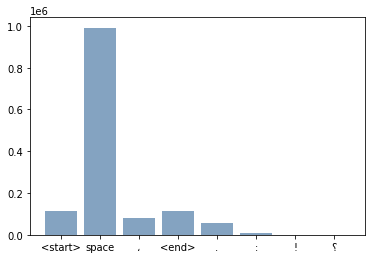

In [32]:
plt.xticks(fontsize =10)
plt.bar(target_plot[0],target_plot[1], color=(0.2, 0.4, 0.6, 0.6))

## 6: Buliding the Model

In [33]:
# initialize the main variables
BUFFER_SIZE = len(input_tensor)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor)//BATCH_SIZE
embedding_dim = 128
units = 1024
vocab_inp_size = len(input_tokenizer.word_index)+1
vocab_tar_size = len(target_tokenizer.word_index)+1

# create dataset
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [34]:
# input / output batches
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 13]), TensorShape([128, 12]))

In [37]:
# Encoder class implementation as Tensorflow guide
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [38]:
# Bahdanau Attention Layer implementation as Tensorflow guide
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.keras.layers.Activation(activation = "tanh")(tf.keras.layers.Add()([self.W1(values), self.W2(hidden_with_time_axis)])))    

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.keras.layers.Activation(activation = "softmax")(tf.keras.layers.Permute((2, 1))(score))
        attention_weights = tf.keras.layers.Permute((2, 1))(attention_weights)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = tf.keras.layers.Multiply()([attention_weights, values])

        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [39]:
# Decoder class implementation as Tensorflow guide
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.keras.layers.Concatenate(axis = -1)([tf.expand_dims(context_vector, 1), x])

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        #output = tf.keras.layers.Dense(self.dec_units)(output)
        # output shape == (batch_size * 1, hidden_size)
        output = tf.keras.layers.Reshape((output.shape[2],))(output)

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [43]:
# 1: initialize the encoder network
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
# sample input
sample_hidden = encoder.initialize_hidden_state()
# sample output
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

# 2: initialize an attention layer
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

# 3: initialize the decoder network
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
# sample output
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                        sample_hidden, sample_output)

In [44]:
# Optimizer and loss function as as Tensorflow guide
# Adam optimizer
optimizer = tf.keras.optimizers.Adam()
# Sparse Categorical Crossentropy
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# loos function, we will use it in traing step
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [45]:
# Checkpoints (Object-based saving)
checkpoint_dir = '/content/drive/MyDrive/datasets/models/npl_project_check_v2/cp.ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")

## 7: Training

In [48]:
# train encode-decode model as Tensorflow guide
@tf.function
def train_step(inp, targ, enc_hidden):

    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
          # passing enc_output to the decoder
          predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

          loss += loss_function(targ[:, t], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [49]:
# start training
EPOCHS = 30

for epoch in range(EPOCHS):
  # epoch start time
  start = time.time()
  # init hidden state
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 10 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix, options=local_device_option)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.1969
Epoch 1 Batch 100 Loss 0.6484
Epoch 1 Batch 200 Loss 0.6060
Epoch 1 Batch 300 Loss 0.5557
Epoch 1 Batch 400 Loss 0.5258
Epoch 1 Batch 500 Loss 0.6964
Epoch 1 Batch 600 Loss 0.7018
Epoch 1 Batch 700 Loss 0.6880
Epoch 1 Batch 800 Loss 0.6727
Epoch 1 Loss 0.6690
Time taken for 1 epoch 334.1332154273987 sec

Epoch 2 Batch 0 Loss 0.6612
Epoch 2 Batch 100 Loss 0.6678
Epoch 2 Batch 200 Loss 0.6960
Epoch 2 Batch 300 Loss 0.6753
Epoch 2 Batch 400 Loss 0.6733
Epoch 2 Batch 500 Loss 0.6840
Epoch 2 Batch 600 Loss 0.6393
Epoch 2 Batch 700 Loss 0.6478
Epoch 2 Batch 800 Loss 0.6683
Epoch 2 Loss 0.6637
Time taken for 1 epoch 319.6639862060547 sec

Epoch 3 Batch 0 Loss 0.6611
Epoch 3 Batch 100 Loss 0.6698
Epoch 3 Batch 200 Loss 0.6287
Epoch 3 Batch 300 Loss 0.6551
Epoch 3 Batch 400 Loss 0.6682
Epoch 3 Batch 500 Loss 0.6666
Epoch 3 Batch 600 Loss 0.6562
Epoch 3 Batch 700 Loss 0.6363
Epoch 3 Batch 800 Loss 0.6140
Epoch 3 Loss 0.6543
Time taken for 1 epoch 320.2249882221222 sec

## 8: Evaluation

In [50]:
def evaluate(sentence):
    '''
    DESCRIPTION:
    This function to predict result
    INPUT: 
    sentence: input sentence 
    OUTPUT: 
    result: predict result
    sentence: input sentence 
    attention_plot: attention weights
    ''' 
    attention_plot = np.zeros((target_max_length, input_max_length))

    #sentence = preprocess_sentence(sentence)
    sentence = '<start> '+sentence + ' <end>'
    
    #print(input_tokenizer.texts_to_sequences([i])[0][0])
    #print(sentence.split(' '))
    inputs = [input_tokenizer.texts_to_sequences([i])[0][0] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=input_max_length,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)

    for t in range(target_max_length):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_tokenizer.index_word[predicted_id] + ' '

        if target_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [51]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  '''
    DESCRIPTION:
    This function to plot attention 
    INPUT: 
    attention: attention weights
    sentence: input sentence 
    predicted_sentence: predict result

    OUTPUT: 
    None
    ''' 
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [63]:
def predict(sentence):
    '''
    DESCRIPTION:
    This function to predict output sentence

    INPUT: 
    sentence: input sentence 

    OUTPUT: 
    None
    ''' 
    result, sentence, attention_plot = evaluate(sentence)

    print('Input:\n %s' % (sentence))

    predict = ''
    sentence_list = sentence.split(' ')
    sentence_list.pop(0) # remove <start>
    result_list = result.split(' ')

    for i in range(len(sentence_list)):
      if (result_list[i]=='space'):
        predict += sentence_list[i]+' '
      else:
        predict += sentence_list[i]+result_list[i]+' '
    print('Predicted punctuation:\n {}'.format(predict))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence_list, result_list)

### 8.1: Prediction

Original Text:  جدد المنتخب المصري فوزه على مضيفه منتخب إي سواتيني 2-صفر خلال الجولة
Input:
 <start> وبهذه النتيجة رفع منتخب الفراعنة رصيده إلى 9 نقاط في <end>
Predicted punctuation:
 وبهذه النتيجة. رفع منتخب الفراعنة رصيده إلى 9 نقاط في، <end><end> 


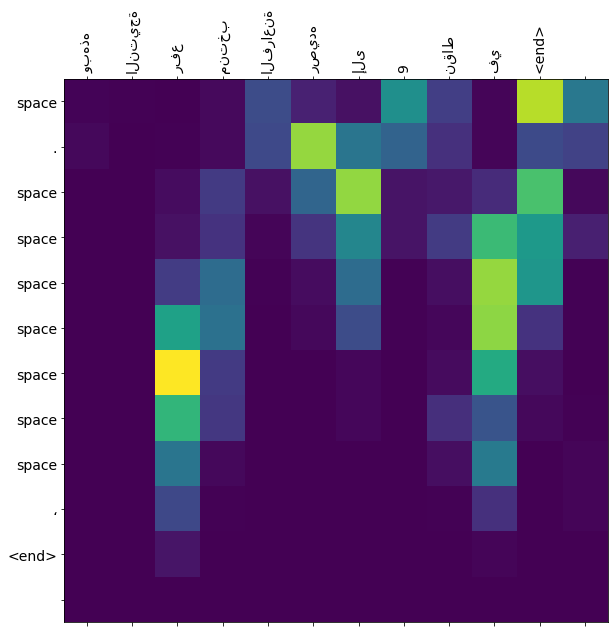

Input:
 <start> المجموعة 11 من التصفيات <end>
Predicted punctuation:
 المجموعة 11 من التصفيات، <end> 


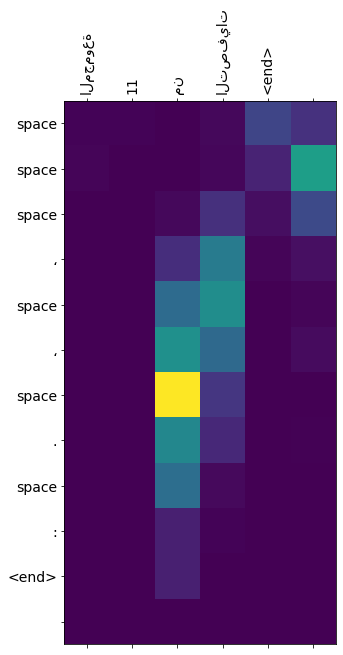

[None, None]

In [65]:

real_sentence = ',وبهذه النتيجة رفع منتخب الفراعنة رصيده إلى 9 نقاط في المجموعة 11 من التصفيات'
sentence = 'وبهذه النتيجة رفع منتخب الفراعنة رصيده إلى 9 نقاط في المجموعة 11 من التصفيات'
print('Original Text: ',real_sentence)

in_seq = sentence.strip().split(' ')
n =10
in_sequances = [" ".join(in_seq[i:i+n]) for i in range(0, len(in_seq), n)]
[predict(s) for s in in_sequances]

### 8.2 Evaluate Model Using BLEU

In [66]:
def evaluate_model( sentences, target):
  '''
  DESCRIPTION:
  This function to evaluate model 
  INPUT: 
  sentences: input vector
  target: target vector
  OUTPUT: 
  actual: real target sentences
  predicted: predict target sentences
  ''' 
  actual, predicted = list(), list()
  outer = tqdm(range(len(sentences)),leave=True,position =0)
  for i, sentence in enumerate(sentences):
    # translate encoded source text
    #sentence = sentence.reshape((1, sentence.shape[0]))
    predict,raw_src,_ = evaluate(sentence)
    predict = predict.replace(' <end> ','')
    raw_target = target[i]
    if i < 10:
      print('src=[%s], target=[%s], predicted=[%s]' % (sentence, raw_target, predict))
    actual.append([raw_target.split()])
    predicted.append(predict.split())
    outer.update(1)

  return actual, predicted

In [67]:
input_ = np.array(source_dataset['sentences'][79399:].map(lambda s: ' '.join(s.split())))
input_ = [ t.replace(' <end>','') for t in input_]
input_ = [ t.replace('<start> ','') for t in input_]

target_ = np.array(target_dataset['sentences'][79399:].map(lambda s: ' '.join(s.split())))
target_ = [ t.replace(' <end>','') for t in target_]
target_ = [ t.replace('<start> ','') for t in target_]

actual, predicted = evaluate_model(input_,target_)

  0%|          | 1/34026 [00:00<7:35:32,  1.24it/s]

src=[الشيء الوحيد المبهم هو وجهته المستقبلية وكان ذلك عندما], target=[space space space space space space ، space space space], predicted=[، space space space space space . space space ،]


  0%|          | 2/34026 [00:01<7:41:59,  1.23it/s]

src=[أعلن أنه سيحط رحاله في الدوري الياباني وسيلتقي توريس], target=[space space space space space space space . space space], predicted=[، space space space space space space . space .]


  0%|          | 3/34026 [00:02<7:43:18,  1.22it/s]

src=[في اليابان مع أسطورة أخرى للكرة الإسبانية وهو اللاعب], target=[space space space space space space space ، space space], predicted=[space ، space space space space space ، space ،]


  0%|          | 4/34026 [00:03<7:42:25,  1.23it/s]

src=[المخضرم أندريس إنييستا الذي سيلعب لصالح نادي فيسيل كوبي], target=[space space space space space space space space space .], predicted=[space space ، space space space space space space .]


  0%|          | 5/34026 [00:04<7:41:24,  1.23it/s]

src=[وأوضح توريس قائلا ساغان توسو كان من أول الأندية], target=[space space space : space space space space space space], predicted=[space ، space space space : space space space ،]


  0%|          | 6/34026 [00:04<7:46:10,  1.22it/s]

src=[التي اهتمت بالتعاقد معي لقد نجحوا في اقناعي بمشروعهم], target=[space space space space ، space space space space space], predicted=[space space space . space space space ، space ،]


  0%|          | 7/34026 [00:05<7:47:07,  1.21it/s]

src=[الرياضي أعتقد أن اليابان والدوري الياباني سيكونان بمثابة تجربة], target=[space ، space space space space space space space space], predicted=[space space space space space ، space ، space ،]


  0%|          | 8/34026 [00:06<7:50:08,  1.21it/s]

src=[رائعة واختتم المهاجم الإسباني المخضرم قائلا لقد قاموا], target=[space . space space space space space : space space], predicted=[. space space space space space : space : space]


  0%|          | 9/34026 [00:07<7:48:10,  1.21it/s]

src=[من أجل أن يعود الفريق للمكانة التي يستحقها عاد], target=[space space space space space space space space . space], predicted=[space space space space space ، space space ، space]


  0%|          | 10/34026 [00:08<7:57:15,  1.19it/s]

src=[نجم برشلونة الإسباني ليونيل ميسي إلى تدريبات المنتخب الأرجنتيني], target=[space space space space space space space space space ،], predicted=[space space ، space space ، space space ، space ،]


100%|██████████| 34026/34026 [7:35:27<00:00,  1.19it/s]

In [68]:
# calculate BLEU score
print('BLEU: %f' % corpus_bleu(actual, predicted))

BLEU: 0.631530
